# BioTopg

BioTopg in the bio-oriented framework for structure-augmented RAG.
Behind the Topg framework lies the idea of "Think On Proposition Graph".

Given a set of documents (pubmed abstracts) the indexing step involves an automatic NER/EL step (done for now by requesting PubTator) and a subsequent propositions/facts extraction as described in the next figure.

At query time (in **local** mode) entities are extracted from the questions and aligned with the entities from the graph allowing to "seed" the question on some nodes in the Graph. The subsequent retrieval step involves a graph traversal algorithm in the graph, considering both the connections between propositions/facts (through entities) and the semantic (embeddings) of the facts.

In this notebook, we are going to see some trivial applications of the BioTopg framework on the BioASQ subset we used in previous notebooks. First, we are going to instantiante a simple system and see the extracted propositions. Then, we will load an already pre-process subset of the BioASQ question and ask some questions from the original datasets.

**BioTopg is a work-in-progress library so future breaking changes are expected. This is a preview**.


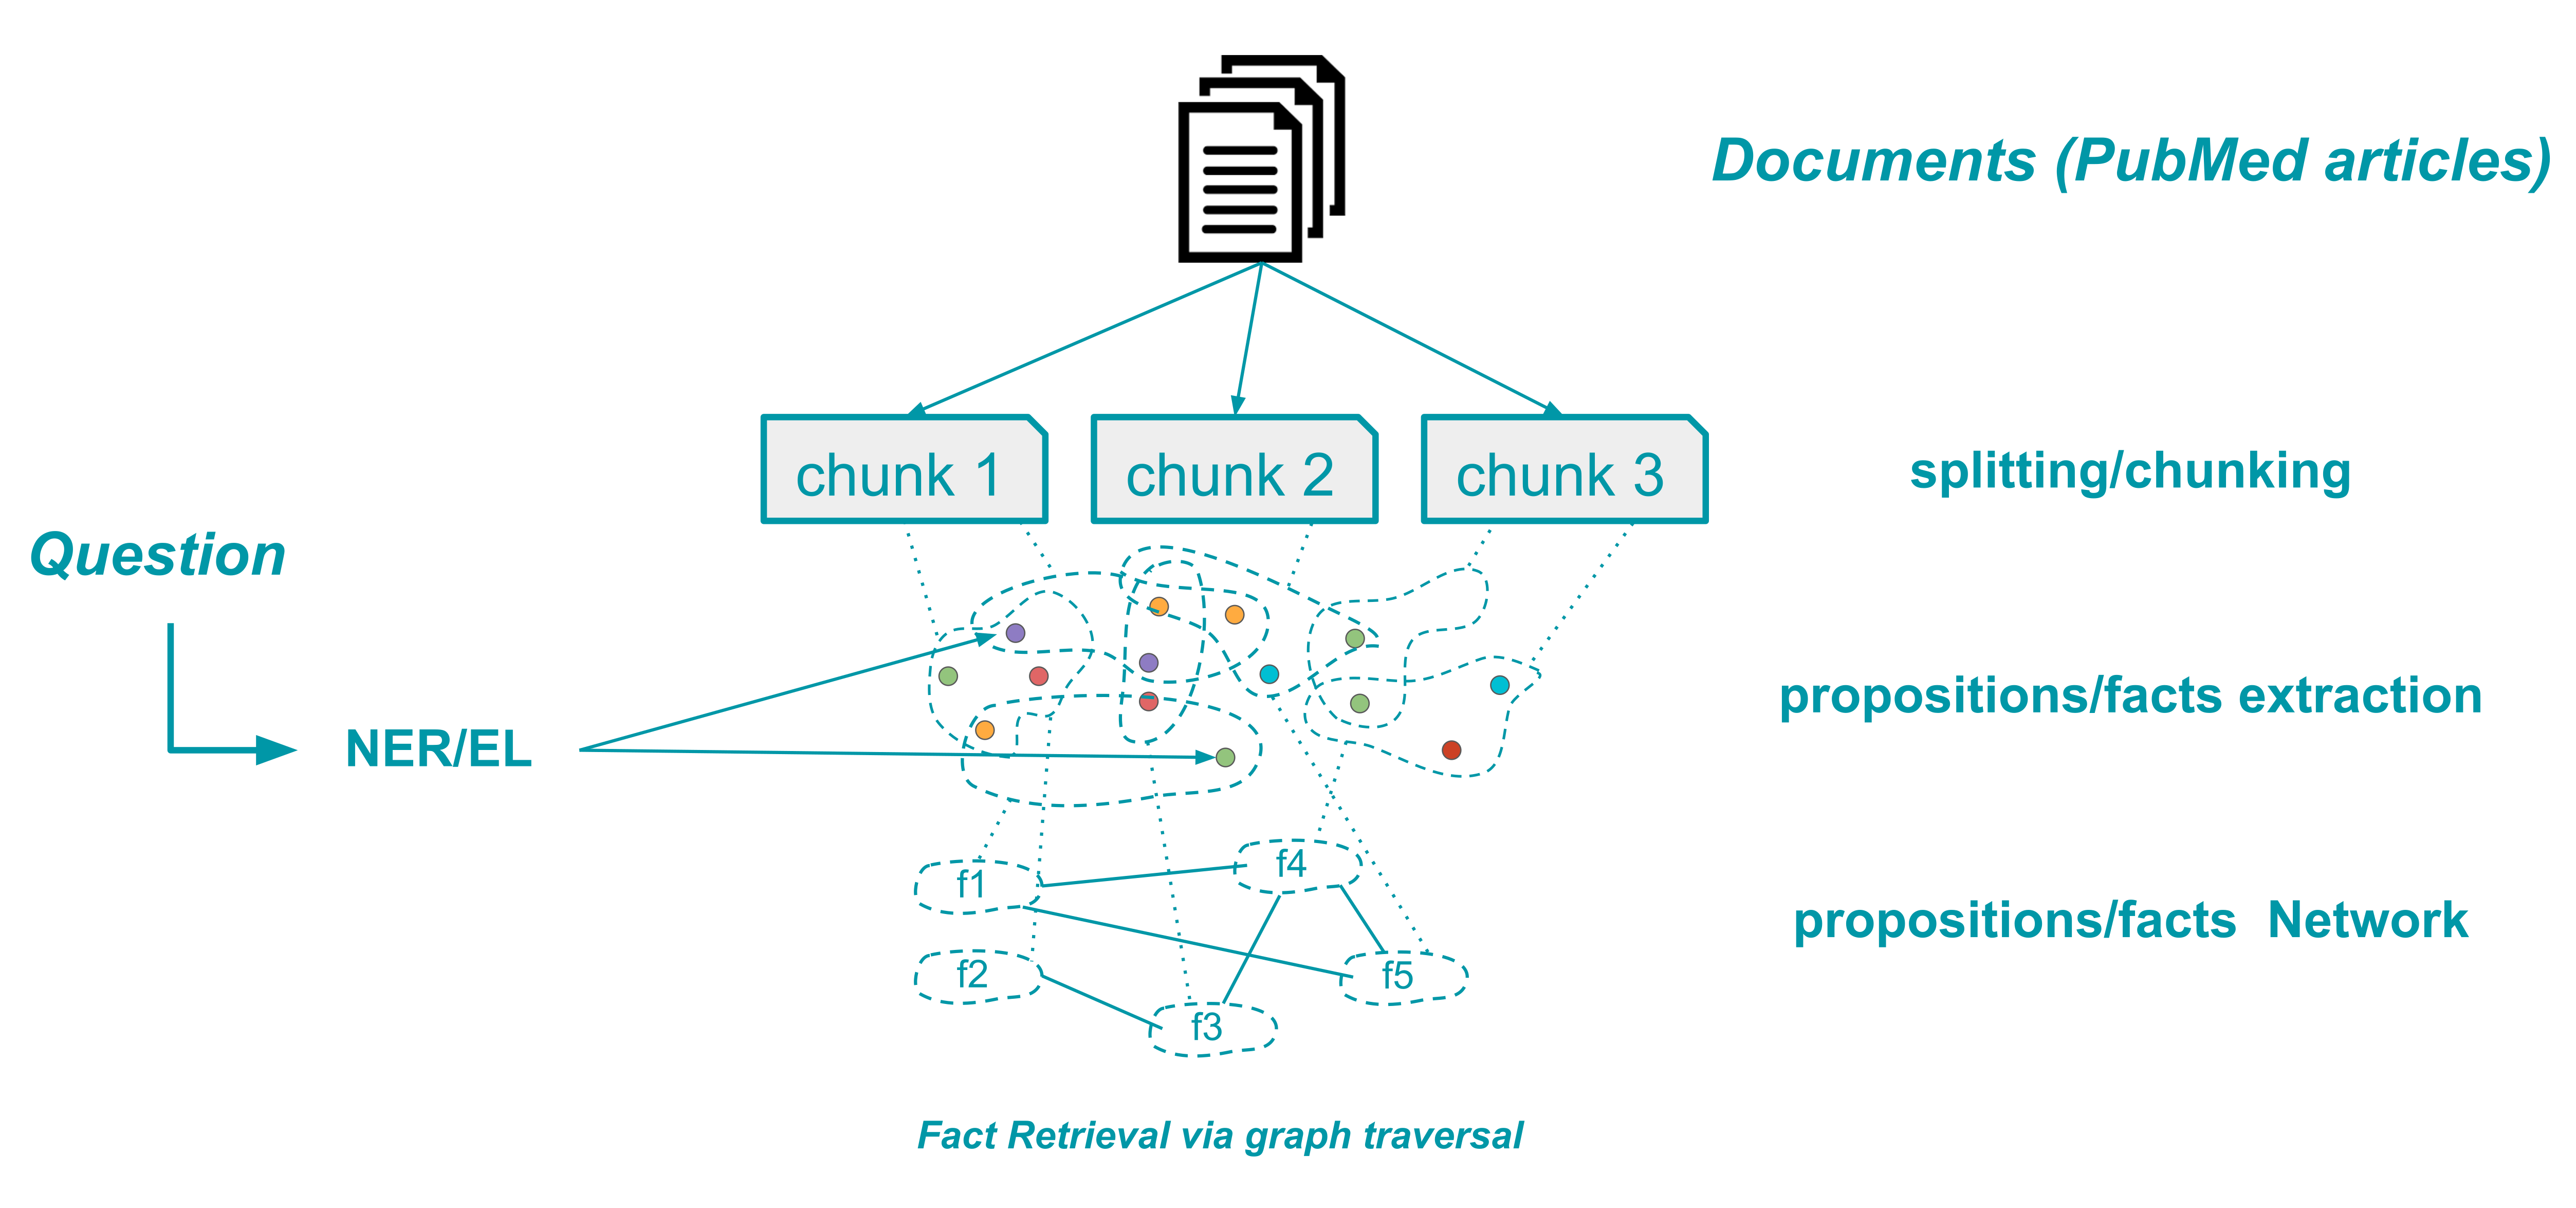

## Settings

In [ ]:
!pip install python-dotenv
!pip install git+https://github.com/idiap/biotopg.git

In [ ]:
import os
import yaml
from biotopg import Biotopg
from dotenv import load_dotenv, find_dotenv
from IPython.display import display, HTML, Markdown
_ = load_dotenv(find_dotenv())

## A quick initialization


You can easy intialize a system by using: ```Biotopg.initialize(path, name)```.

This will automatically creates a directory at the provided `path` and a default configuration file. We are going to let the configuration by default for this demonstration, but of course you can edit the configuration file to change the used embeddings models, integrate demonstrations for the proposition extraction, etc.



In [ ]:
Biotopg.initialize("outputs", "PubMed")

Then, load the yaml file and use it to initialize a system.

In [ ]:
config_path = "outputs/PubMed/config.yaml"
with open(config_path, "r") as file:
    system_config = yaml.safe_load(file)

system = Biotopg(config=system_config)

<style>body {text-align: justify}</style>

To insert documents (only PubMed abstracts for now) simply pass them as a list of PubMed identifiers. The indexing module will automatically handle NER/EL with PubTator, propositions extractions, encoding with the embedding models and indexing in the vector/sqlite database.

### What is this proposition extraction ?

Here is an abstract:

**Title: Progesterone neuroprotection in traumatic CNS injury and motoneuron degeneration.**

**Abstract:** Studies on the neuroprotective and promyelinating effects of progesterone in the nervous system are of great interest due to their potential clinical connotations. In peripheral neuropathies, progesterone and reduced derivatives promote remyelination, axonal regeneration and the recovery of function. In traumatic brain injury (TBI), progesterone has the ability to reduce edema and inflammatory cytokines, prevent neuronal loss and improve functional outcomes. Clinical trials have shown that short-and long-term progesterone treatment induces a significant improvement in the level of disability among patients with brain injury. In experimental spinal cord injury (SCI), molecular markers of functional motoneurons become impaired, including brain-derived neurotrophic factor (BDNF) mRNA, Na,K-ATPase mRNA, microtubule-associated protein 2 and choline acetyltransferase (ChAT). SCI also produces motoneuron chromatolysis. Progesterone treatment restores the expression of these molecules while chromatolysis subsided. SCI also causes oligodendrocyte loss and demyelination. In this case, a short progesterone treatment enhances proliferation and differentiation of oligodendrocyte progenitors into mature myelin-producing cells, whereas prolonged treatment increases a transcription factor (Olig1) needed to repair injury-induced demyelination. Progesterone neuroprotection has also been shown in motoneuron neurodegeneration. In Wobbler mice spinal cord, progesterone reverses the impaired expression of BDNF, ChAT and Na,K-ATPase, prevents vacuolar motoneuron degeneration and the development of mitochondrial abnormalities, while functionally increases muscle strength and the survival of Wobbler mice. Multiple mechanisms contribute to these progesterone effects, and the role played by classical nuclear receptors, extra nuclear receptors, membrane receptors, and the reduced metabolites of progesterone in neuroprotection and myelin formation remain an exciting field worth of exploration.


Instead of extracting triples (s, p, o) we are going to extract propositions that will act as hyperedges, connecting $>=2$ entities.

Here is a sample of some propositions we can extract (with the LLM):


- <font color='lightgreen'>Progesterone</font> provides neuroprotection in <font color='orange'>traumatic CNS injury</font>
- <font color='lightgreen'>Progesterone</font> provides neuroprotection in <font color='orange'>motoneuron degeneration</font>
- <font color='lightgreen'>Progesterone</font> reduces <font color='orange'>edema</font> in <font color='orange'>traumatic brain injury.</font>
- Short- and long-term <font color='lightgreen'>progesterone</font> treatment significantly improves the level of disability in <font color='cyan'>patients</font> with <font color='orange'>brain injury</font>.

- <font color='lightgreen'>Progesterone</font> treatment restores the expression of <font color='pink'>BDNF</font>, <font color='pink'>microtubule-associated protein 2</font>, and <font color='pink'>choline acetyltransferase</font> (ChAT) after <font color='orange'>spinal cord injury</font>.
...

* * *



Identified entities act as bridges between propositions, then creating a network of facts we can explore.

In [ ]:
batch_pmids = ["11299965", "18218922", "16245277", "14633596", "9560222", "10797941", "23194061", "12049630", "7758945"]
system.insert_pmids(pmids=batch_pmids)

Here we can export and explore some of the extracted propositions.

In [ ]:
import os
outdir = "outputs"
system.store.export_all_hyperpropositions(
    os.path.join(outdir, "hyperpropositions.json")
)
system.store.export_all_passages(os.path.join(outdir, "passages.json"))

## Simple queries with BioTopg

First we are going to make a simple query using the questions we have seen in other notebooks. Then, considering all the subset of the BioASQ dataset, you will be able to browse and see the provided answer for random BioASQ question of different types: list, yes/no, factoids and summary.

In [22]:
# Some default retrieval parameters
retriever_args = {
    "initial_retriever_args": {
        "e_syn_k": 5,
        "e_syn_threshold": 0.80,
        "lambda_mmr": 1.0,
        "p_k": 20
    },
    "q": 0.5,
    "damping": 0.5,
    "cosine_threshold": 0.4,
    "temperature": 0.1,
    "top_k": 20,
    "use_passage_links": True
}


In [ ]:
# if new documents have been added since, it is recommended to reload the graph. When reloading the graph.
system.retriever.load_graphs(force_reload=True)

question = "What is Tastin ?"
qa_mode = "local"
max_iter = 1
predicted_answer, documents, _memory = system.query(
    question,
    mode=qa_mode,
    max_iter=max_iter,
    retriever_args=retriever_args,
)

print("Answer:", predicted_answer)
print("Documents:")
for pmid, data in documents.items():
    print(f"PMID: {pmid}")
    print(f"Passage ID: {data['passage_id']}")
    print(f"Text: {data['text']}")
    print("Facts:")
    for fact in data["facts"]:
        print(f"- {fact}")
    print()

## Sample queries

First, we need to load and initialize a pre-processed system containing the $>1700$ PubMed abstracts.

In [ ]:
!apt-get install -y git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/mdelmas/Biotopg-bioasq

In [16]:
! mkdir -p outputs
! mv /content/Biotopg-bioasq/BioASQ.zip /content/outputs

In [ ]:
!unzip /content/outputs/BioASQ.zip -d outputs/

In [ ]:
config_path = "/content/outputs/BioASQ/config_bioasq.yaml"
with open(config_path, "r") as file:
    system_config = yaml.safe_load(file)

system = Biotopg(config=system_config)

### Q1: Which genes have been associated with Cerebral Cavernous Malformation ?

In [ ]:
question = "Which genes have been associated with Cerebral Cavernous Malformation ?"
qa_mode = "local"
max_iter = 1
predicted_answer, documents, _memory = system.query(
    question,
    mode=qa_mode,
    max_iter=max_iter,
    retriever_args=retriever_args,
)

print("Answer:", predicted_answer)
print("Documents:")
for pmid, data in documents.items():
    print(f"PMID: {pmid}")
    print(f"Passage ID: {data['passage_id']}")
    print(f"Text: {data['text']}")
    print("Facts:")
    for fact in data["facts"]:
        print(f"- {fact}")
    print()


### Q2: Which genes have been associated with Cerebral Cavernous Malformation ?

In [ ]:
question = "Which genes have been associated with Cerebral Cavernous Malformation ?"
qa_mode = "local"
max_iter = 1
predicted_answer, documents, _memory = system.query(
    question,
    mode=qa_mode,
    max_iter=max_iter,
    retriever_args=retriever_args,
)

print("Answer:", predicted_answer)
print("Documents:")
for pmid, data in documents.items():
    print(f"PMID: {pmid}")
    print(f"Passage ID: {data['passage_id']}")
    print(f"Text: {data['text']}")
    print("Facts:")
    for fact in data["facts"]:
        print(f"- {fact}")
    print()

## Randomly sample question and answer them.

In [24]:
import json
import random
with open("/content/sampled_questions.json", "r") as f:
    sampled_questions = json.load(f)

n_questions = len(sampled_questions)

In [ ]:
# take a number between 0 and n-1
sampled_index = random.randint(0, n_questions-1)
question = sampled_questions[sampled_index]["body"]
ideal_answer = sampled_questions[sampled_index]["ideal_answer"]
question_type = sampled_questions[sampled_index]["type"]

qa_mode = "local"
max_iter = 2 # you can change this
predicted_answer, documents, _memory = system.query(
    question,
    mode=qa_mode,
    max_iter=max_iter,
    retriever_args=retriever_args,
)
display(Markdown(f"**Question:** {question} (type: {question_type})"))
display(Markdown(f"**Predicted Answer:** {predicted_answer}"))
display(Markdown(f"**Ideal Answer:** {ideal_answer}"))

print("\n\nDocuments:")
for pmid, data in documents.items():
    print(f"PMID: {pmid}")
    print(f"Passage ID: {data['passage_id']}")
    print(f"Text: {data['text']}")
    print("Facts:")
    for fact in data["facts"]:
        print(f"- {fact}")
    print()

In [ ]:
system.show_reasoning()